# Chapter 19.  Intertrial phase clustering
Phase is a circular variable, so it cannot be averaged using the standard arithmetic mean.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from numpy.polynomial.polynomial import polyfit
from scipy.stats import spearmanr, pearsonr, kstest, rankdata
from numpy.fft import fft, ifft

### Fig. 19.1

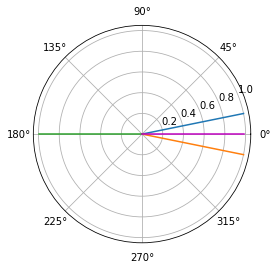

In [2]:
a = np.array((.2, 2*np.pi-.2))

plt.polar([[0,0], [*a]], [[0,0],[1,1]])
plt.polar([0, np.mean(a)], [0, 1])

# plot the avg vector
plt.polar([0, np.angle(np.mean(np.exp(1j*a)))],
          [0, np.abs(np.mean(np.exp(1j*a)))], 'm')

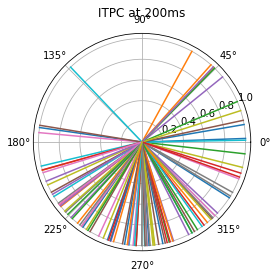

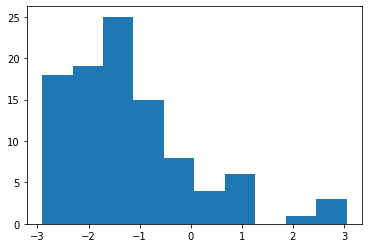

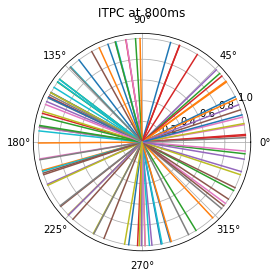

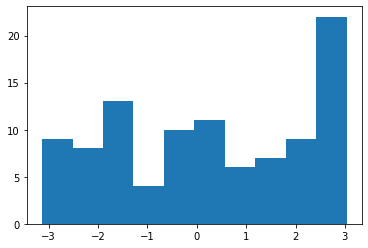

In [3]:
data = scipy.io.loadmat('../data/sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]
EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

def nextpow2(i):
    n = 1
    while n < i: n *= 2
    return n

chan2plot= 'Pz'
center_freq = 12  # in hz
times2plot = (200, 800)  # in msec from stim onset

n_wavelet = EEGpnts
n_data = EEGpnts * EEGtrials
n_convolution = n_wavelet + n_data
n_conv_pow2 = nextpow2(n_convolution)

# create the wavelet
time = np.arange(-1*EEGpnts/EEGsrate/2, EEGpnts/EEGsrate/2, 1/EEGsrate)
wavelet = np.exp(2*1j*np.pi*center_freq*time) * np.exp(-time**2/(2*((4/(2*np.pi*center_freq))**2)))/center_freq

# get fft of data
eeg_fft = fft(EEGdata[EEGchanlocslabels==chan2plot].flatten(order='f'), n=n_conv_pow2)
eeg_conv = ifft(fft(wavelet, n_conv_pow2) * eeg_fft)
eeg_conv = eeg_conv[:n_convolution]

eeg_conv = np.reshape(eeg_conv[EEGpnts//2: -1*EEGpnts//2], (EEGpnts, EEGtrials), order='f')


idx = np.argmin(np.abs(EEGtimes - times2plot[0]))
plt.polar(np.array([np.zeros(EEGtrials),np.angle(eeg_conv[idx])]), 
                 np.array([np.zeros(EEGtrials), np.ones(EEGtrials)]));
plt.title(f'ITPC at {times2plot[0]:d}ms')

plt.figure()
plt.hist(np.angle(eeg_conv[idx]))

plt.figure()
idx = np.argmin(np.abs(EEGtimes - times2plot[1]))
plt.polar(np.array([np.zeros(EEGtrials),np.angle(eeg_conv[idx])]), 
                 np.array([np.zeros(EEGtrials), np.ones(EEGtrials)]))
plt.title(f'ITPC at {times2plot[1]:d}ms')

plt.figure()
plt.hist(np.angle(eeg_conv[idx]));

### Figure 19.3

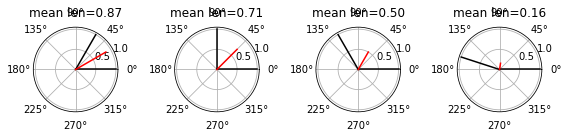

In [4]:
vectors = [(0, np.pi/3), (0, np.pi/2), (0, np.pi*2/3), (0, np.pi*.9)]
fig, ax = plt.subplots(1,4, subplot_kw={'projection': 'polar'}, figsize=(8,4))

for i, v in enumerate(vectors):
    ax[i].plot([0,v[0]], [0,1], 'k')
    ax[i].plot([0,v[1]], [0,1], 'k')
    
    mean_vec = np.mean(np.exp(1j * np.array(v)))
    ax[i].plot([0, np.angle(mean_vec)], [0, np.abs(mean_vec)], 'r')
    ax[i].set(title=f'mean len={np.abs(mean_vec):.2f}')

fig.tight_layout()

### Figure 19.4

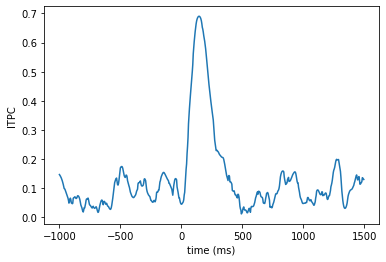

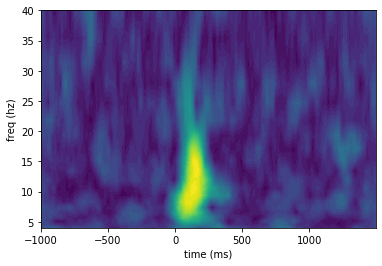

In [5]:
chan2plot= 'Pz'
center_freq = 12  # in hz
times2plot = (200, 800)  # in msec from stim onset

n_wavelet = EEGpnts
n_data = EEGpnts * EEGtrials
n_convolution = n_wavelet + n_data
n_conv_pow2 = nextpow2(n_convolution)

# create the wavelet
time = np.arange(-1*EEGpnts/EEGsrate/2, EEGpnts/EEGsrate/2, 1/EEGsrate)
wavelet = np.exp(2*1j*np.pi*center_freq*time) * np.exp(-time**2/(2*((4/(2*np.pi*center_freq))**2)))/center_freq

# get fft of data
eeg_fft = fft(EEGdata[EEGchanlocslabels==chan2plot].flatten(order='f'), n=n_conv_pow2)
eeg_conv = ifft(fft(wavelet, n_conv_pow2) * eeg_fft)
eeg_conv = eeg_conv[:n_convolution]

eeg_conv = np.reshape(eeg_conv[EEGpnts//2: -1*EEGpnts//2], (EEGpnts, EEGtrials), order='f')

plt.plot(EEGtimes, np.abs(np.exp(1j*np.angle(eeg_conv)).mean(1)))
plt.xlabel('time (ms)')
plt.ylabel('ITPC')

# TF plot of itpc

frequencies = np.logspace(np.log10(4), np.log10(40), 20)
s = np.logspace(np.log10(3),np.log10(10),len(frequencies))/(2*np.pi*frequencies)

itpc = np.zeros((len(frequencies),EEGpnts))

for fi, ff in enumerate(frequencies):
    # create wavelet
    wavelet = np.exp(2*1j*np.pi*ff*time) * np.exp(-time**2/(2*s[fi]**2))/ff

    # convolution
    eeg_conv = ifft(fft(wavelet, n_conv_pow2) * eeg_fft)
    eeg_conv = eeg_conv[:n_convolution]
    eeg_conv = np.reshape(eeg_conv[EEGpnts//2: -1*EEGpnts//2], (EEGpnts, EEGtrials), order='f')

    # extract itpc
    itpc[fi,:] = np.abs(np.mean(np.exp(1j*np.angle(eeg_conv)),1))

plt.figure()
plt.contourf(EEGtimes, frequencies, itpc, 40)
plt.gca().set(xlabel='time (ms)', ylabel='freq (hz)');

### Figure 19.5

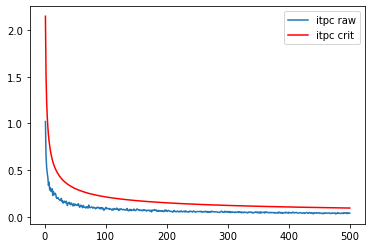

In [6]:
n_trials = 500
itpc_fake = np.zeros(n_trials)

for n in range(n_trials):
    for i in range(50):
        itpc_fake[n] = itpc_fake[n] + np.abs(np.mean(np.exp(1j*(np.random.rand(n+1)*2*np.pi-np.pi))))
itpc_fake = itpc_fake/i

itpc_fake_z = np.arange(1,n_trials+1)*itpc_fake**2
itpc_fake_p = np.exp(np.sqrt(1+4*np.arange(1,n_trials+1)+4*((np.arange(1,n_trials+1)**2) - (np.arange(1,n_trials+1)*itpc_fake)**2))-(1+2*np.arange(1,n_trials+1)))
itpc_fake_crit = np.sqrt(-np.log(.01)/np.arange(1,n_trials+1))

plt.plot(np.arange(1,n_trials+1), itpc_fake, label='itpc raw')
plt.plot(np.arange(1,n_trials+1), itpc_fake_crit, 'r', label='itpc crit')
plt.legend();

### Figure 19.6

In [7]:
chan2plot= 'FCz'
center_freq = 12  # in hz
times2plot = (200, 800)  # in msec from stim onset

n_wavelet = EEGpnts
n_data = EEGpnts * EEGtrials
n_convolution = n_wavelet + n_data
n_conv_pow2 = nextpow2(n_convolution)

# create the wavelet
time = np.arange(-1*EEGpnts/EEGsrate/2, EEGpnts/EEGsrate/2, 1/EEGsrate)
wavelet = np.exp(2*1j*np.pi*center_freq*time) * np.exp(-time**2/(2*((4/(2*np.pi*center_freq))**2)))/center_freq

# get fft of data
eeg_fft = fft(EEGdata[EEGchanlocslabels==chan2plot].flatten(order='f'), n=n_conv_pow2)
eeg_conv = ifft(fft(wavelet, n_conv_pow2) * eeg_fft)
eeg_conv = eeg_conv[:n_convolution]

eeg_conv = np.reshape(eeg_conv[EEGpnts//2: -1*EEGpnts//2], (EEGpnts, EEGtrials), order='f')


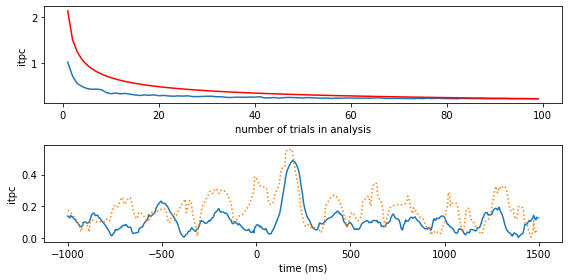

In [8]:
itpc = np.zeros(EEGtrials)

for n in range(EEGtrials):
    # select diff sets of random trials
    for i in range(50):
        trials2use = np.random.permutation(np.arange(EEGtrials))[:n+1]
        itpc[n] = itpc[n] + np.mean(np.abs(np.mean(np.exp(1j*np.angle(eeg_conv[281:371,trials2use])), 1)))
itpc = itpc/i

itpc_z = np.arange(1, EEGtrials+1)*itpc**2
itpc_p = np.exp(np.sqrt(1+4*np.arange(1,EEGtrials+1)+4*((np.arange(1,EEGtrials+1)**2) - (np.arange(1,EEGtrials+1)*itpc)**2))-(1+2*np.arange(1,EEGtrials+1)))
itpc_crit = np.sqrt(-np.log(.01)/np.arange(1,EEGtrials+1))

fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].plot(np.arange(1,EEGtrials+1), itpc, label='itpc raw')
ax[0].plot(np.arange(1,EEGtrials+1), itpc_crit, 'r', label='itpc crit')
ax[0].set(xlabel= 'number of trials in analysis', ylabel='itpc')


# this will look diff than the book bc it uses random samples
random_trials = np.random.permutation(np.arange(EEGtrials))[:20]
ax[1].plot(EEGtimes, np.abs(np.mean(np.exp(1j * np.angle(eeg_conv)), 1)))
ax[1].plot(EEGtimes, np.abs(np.mean(np.exp(1j*np.angle(eeg_conv[:, random_trials])),1)), ":")
ax[1].set(xlabel='time (ms)', ylabel='itpc')

fig.tight_layout()

## Figure 34.8

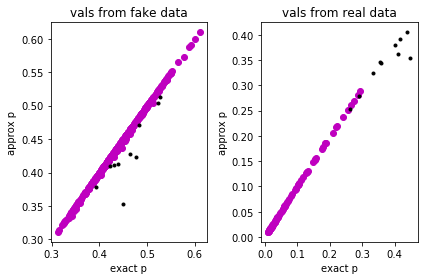

In [9]:
# p-values under assumption of von Mises distribution
approx_pval_fake = np.exp(-itpc_fake_z)
approx_pval_real = np.exp(-itpc_z)

ncutoff = 10

fig, ax = plt.subplots(1,2)
ax[0].plot(itpc_fake_p[ncutoff:], approx_pval_fake[ncutoff:],'mo')
ax[0].plot(itpc_fake_p[:ncutoff:], approx_pval_fake[:ncutoff], 'k.')
ax[0].set(title= "vals from fake data",  xlabel='exact p', ylabel='approx p')

ax[1].plot(itpc_p[ncutoff:], approx_pval_real[ncutoff:],'mo')
ax[1].plot(itpc_p[:ncutoff:], approx_pval_real[:ncutoff], 'k.')
ax[1].set(title= "vals from real data", xlabel='exact p', ylabel='approx p')

fig.tight_layout()

### Figure 19.7

Text(0, 0.5, 'frequency (hz)')

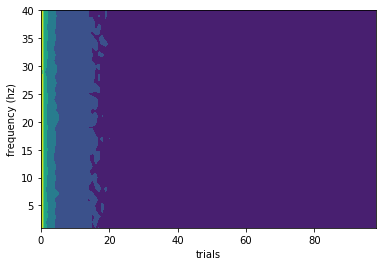

In [14]:
frequencies = np.arange(1,41)


# create the wavelet
itpc_by_n_and_f = np.zeros((len(frequencies), EEGtrials))
for fi, ff in enumerate(frequencies):
    # create wavelet
    wavelet = np.exp(2*1j*np.pi*center_freq*time) * np.exp(-time**2/(2*((4/(2*np.pi*center_freq))**2)))/center_freq;

    # convolution
    eeg_conv = ifft(fft(wavelet, n_conv_pow2) * eeg_fft)
    eeg_conv = eeg_conv[:n_convolution]
    eeg_conv = np.reshape(eeg_conv[EEGpnts//2: -1*EEGpnts//2], (EEGpnts, EEGtrials), order='f')
    
    for n in range(EEGtrials):
    # select diff sets of random trials
        for i in range(50):
            trials2use = np.random.permutation(np.arange(EEGtrials))[:n+1]
            itpc_by_n_and_f[fi, n] = itpc_by_n_and_f[fi, n] + np.mean(np.abs(np.mean(np.exp(1j*np.angle(eeg_conv[281:371,trials2use])), 1)))
        
itpc_by_n_and_f = itpc_by_n_and_f/i

plt.contourf(np.arange(EEGtrials), frequencies, itpc_by_n_and_f)
plt.xlabel('trials')
plt.ylabel('frequency (hz)')

### Figure 19.8

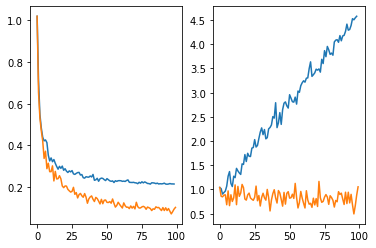

In [15]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(itpc)
ax[0].plot(itpc_fake[:100])

ax[1].plot(itpc_z)
ax[1].plot(itpc_fake_z[:100])

### Figure 19.9

In [16]:
from scipy.spatial import distance

def dsearchn(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    return nodes[closest_index]

In [18]:
chan2plot = 'FCz'

frequencies = np.arange(1, 41)

n_wavelet = EEGpnts
n_data = EEGpnts * EEGtrials
n_convolution = n_wavelet + n_data
n_conv_pow2 = nextpow2(n_convolution)

# create the wavelet
time = np.arange(-1*EEGpnts/EEGsrate/2, EEGpnts/EEGsrate/2, 1/EEGsrate)

baseline_time = [-300, -100]
# baseidx = dsearchn(EEGtimes, np.arange(baseline_time[0], dsearchn(EEGtimes, baseline_time[1]) ))
